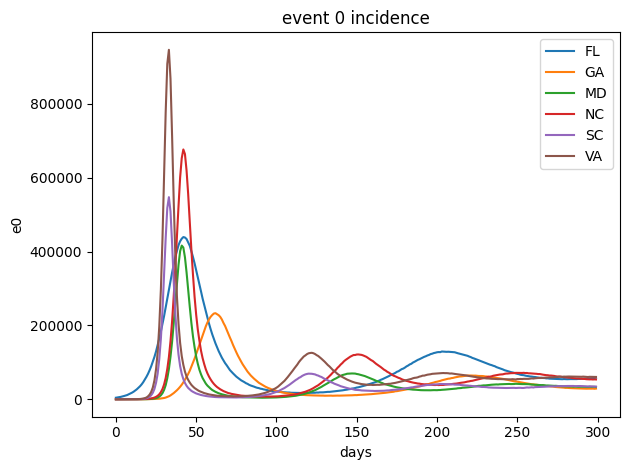

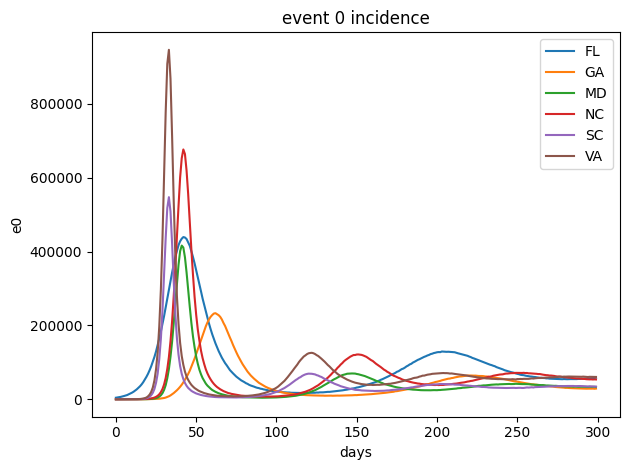

In [2]:

from datetime import date
from functools import partial

import numpy as np

from epymorph.data import geo_library, ipm_library, mm_library
from epymorph.initializer import single_location
from epymorph.simulation import Simulation
from epymorph.run import plot_event, plot_pop
from epymorph.util import Duration, progress, stridesum
import matplotlib.pyplot as plt


# Note: the 'library' dictionaries contain functions which load the named component,
# so you have to apply the function to get the _actual_ component.

# The 'pei' model family (IPM/MM/GEO) implement an SIRS model in 6 US states.
# (Remember: it is possible to mix-and-match the models!)

def beta(t):
        
    betaMax1=0.1
    theta=0

    return 0.3+betaMax1*(1.0-np.cos(theta+t/7/52*2*np.pi))  

beta_cos = [0.4,0.4,0.6,0.6,0.8,0.8]

sim = Simulation(
    geo=geo_library['pei'](),
    ipm_builder=ipm_library['sirs'](),
    mvm_builder=mm_library['pei']()
)

out = sim.run(
    param={
        'beta':beta_cos,
        'gamma':0.25,
        'xi':1/90,
        'theta': 0.1,
        'move_control': 0.9,
        'infection_duration': 4.0,
        'immunity_duration': 90.0,
    },
    start_date=date(2015, 1, 1),
    duration_days=300,
    initializer=partial(single_location, location=0, seed_size=10_000),
    rng=np.random.default_rng(1)
)

sim2 = Simulation(
    geo=geo_library['pei'](),
    ipm_builder=ipm_library['sirs'](),
    mvm_builder=mm_library['pei']()
)

out2 = sim2.run(
    param={
        'beta':beta_cos,
        'gamma':0.25,
        'xi':1/90,
        'theta': 0.1,
        'move_control': 0.9,
        'infection_duration': 4.0,
        'immunity_duration': 90.0,
    },
    start_date=date(2015, 1, 1),
    duration_days=300,
    initializer=partial(single_location, location=0, seed_size=10_000),
    rng=np.random.default_rng(1)
)


#plot_pop(out, 0)  # prevalence for all compartments in population 0.
plot_event(out, 0)  # incidence data for the S->I event across all populations.
plot_event(out2,0)

incidence = []
for pop_idx in range(out.ctx.nodes):
        values = stridesum(
            out.incidence[:, pop_idx, 0], len(out.ctx.clock.taus))
        incidence.append(values)
incidence = (np.array(incidence))

import pandas as pd

df = pd.DataFrame(incidence)
df.to_csv('../data_sets/epy_inc.csv')